# PY525 Fall 2024 - Homework 10 (Bonus)

## Two particles in a box

In this exercsise we study a two-body bound state in a periodic box with a simple lattice discretization.  That is, we assume that the system is defined in a three-dimensional cubic volume with edge length $L$.

For the interaction between the two particles, we use the familiar (from previous exercises) attractive Gaussian potential with depth $V_0={-}4.0$ and range $R=2.0$.  As usual, we assume natural units with $m = 2\mu = 1$.

For convenience, the calculation is performed with the lattice spacing $a$ set to unity.  This can be achieved by expressing all dimensionful quantities **in units of $a$**.  In particular, we can assume that $L$ is an integer.

For the two-body system, we need a single relative coordinate $\vec{x}$, which in 3D has three cartesian components that we label as $x_1$, $x_2$, $x_3$ that by the above assumption each run from $0$ to $L-1$ in integer steps.

*(a)* Overall, we have $L^3$ different configurations and we can use numbers from $0$ to $L^3-1$ to label these states.  These labels are then also the indices of the rows and columns for the Hamiltionian represented as a matrix.  Write a set of helper functions that for each possible state return the components $x_1$, $x_2$, $x_3$, respectively.

**Hint:** You need to invert the relation
\begin{equation}
  i = x_1 + L \times x_2 + L^2 \times x_3
\end{equation}
to extract $x_{1,2,3}$ from an index $i \in \{0,\cdots L^3-1\}$.

In [1]:
import numpy as np
import scipy.sparse as ss
import scipy.ndimage as sn
import matplotlib.pyplot as plt

In [2]:
# calculate the relative coordinates (x1, x2, x3) from a flattened vector with index i = x1 + N*x2 + N^2*x3
# given a relative coordinate index i and the number of lattice points N
def positions(i, N):
  if i < 0 or i > (N**3 - 1): raise ValueError(f"i must be between 0 and {N**3 - 1}")
  x3 = i // N**2
  x2 = (i % N**2) // N
  x1 = i % N
  return (x1, x2, x3)

*(b)* Write a function that returns the distance between the two particles for a given overall configuration, **taking into account the periodic boundary condition.**

In [3]:
# calculate relative distance between particles accounting for periodic BCs
# given a relative coordinate index i and the number of lattice points N
def calc_distance(i, N):
  x1, x2, x3 = positions(i, N)
  # if relative distance is larger than N/2, wrap around (fold range to [-N/2, N/2))
  x1 = (x1 + N/2) % N - N/2
  x2 = (x2 + N/2) % N - N/2
  x3 = (x3 + N/2) % N - N/2
  distance = (x1*x1 + x2*x2 + x3*x3)**(1 / 2)
  return distance

*(c)* Construct the finite-volume Hamiltonian as a sparse matrix, using the infrastructure from `scipy.sparse` that was shown in the lecture.

In [4]:
# construct kinetic energy matrix, -1/a^2*Laplacian, from central difference
# given physical lattice spacing a and the number of lattice points N
# (vectorize if speed needed)
def construct_T(a, N):
  # 7 entries for each site
  data = np.zeros(7 * N**3, dtype=np.float64)
  rows = np.zeros(7 * N**3, dtype=np.uint32)
  cols = np.zeros(7 * N**3, dtype=np.uint32)
  k = 0
  for i in range(N**3):
    x1, x2, x3 = positions(i, N)

    # calculate nearest neighbors
    nearest_neighbors = [( (x1 + dx1) % N, (x2 + dx2) % N, (x3 + dx3) % N ) for
                         dx1, dx2, dx3 in [(1, 0, 0), (-1, 0, 0), (0, 1, 0),
                                            (0, -1, 0), (0, 0, 1), (0, 0, -1)]]
    # add diagonal portion
    data[k] = -6.0
    rows[k] = i
    cols[k] = i
    k += 1

    # add nearest neighbors portion
    for neighbor in nearest_neighbors:
      u1, u2, u3 = neighbor
      data[k] = 1.0
      rows[k] = i
      cols[k] = u1 + N*u2 + N**2*u3
      k += 1

  T_matrix = ss.coo_matrix((data, (rows, cols)), shape=(N**3, N**3)).tocsr() * (-1 / a**2)
  return T_matrix

# construct potential matrix assuming attractive Gaussian potential
# given physical lattice spacing a, the number of lattice points N, a Gaussian
# depth V0, and a Gaussian width R
# (vectorize if speed needed)
def construct_V(a, N, V0=4.0, R=2.0):
  vs = np.zeros(N**3)
  for i in range(N**3):
    ri = calc_distance(i, N)
    vs[i] = -V0 * np.exp(-(ri * a)**2 / R**2)
  return ss.diags(vs, format='csr')

*(d)* Calculate the low-energy spectrum of the Hamiltonian matrix using tools from `scipy.linalg.sparse` and plot the ground-state energy as a function of $L$.

In [5]:
# test example

# Constants (assuming natural units of hbar = 2mu = 1)
N = 32            # number of lattice points
L = 8             # box size
a_phys = L / N    # lattice spacing
V0 = 4            # Gaussian depth
R = 2.0           # Gaussian width

# compute H matrix
H = construct_T(a_phys, N) + construct_V(a_phys, N, V0, R)
eigenvalues, eigenvectors = ss.linalg.eigsh(H, k=5, which='SA')

The five largest eigenvalues are [-1.50698117 -0.23062823 -0.23062823 -0.23062823 -0.04631128]


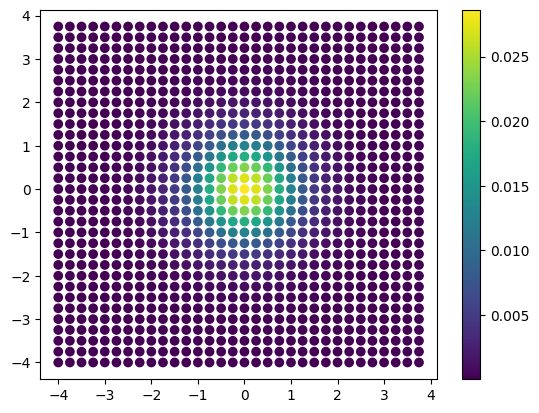

In [6]:
print(f"The five largest eigenvalues are {eigenvalues}")

psi_3d = np.reshape(eigenvectors[:,0], (N, N, N))
values = np.abs(psi_3d.flatten())**2 / a_phys**3

ys2d, xs2d = np.indices((N, N))
xs2d = ( (xs2d.flatten() + N / 2) % N - N / 2) * a_phys
ys2d = ( (ys2d.flatten() + N / 2) % N - N / 2) * a_phys
plt.scatter(xs2d, ys2d, c=values[:N**2]*a_phys, cmap='viridis')
plt.colorbar()
plt.show()

# 3D visualization (commented out only because the slice gives more information)
# zs, ys, xs = np.indices((N, N, N))
# xs = ( (xs.flatten() + N / 2) % N - N / 2 ) * a_phys
# ys = ( (ys.flatten() + N / 2) % N - N / 2 ) * a_phys
# zs = ( (zs.flatten() + N / 2) % N - N / 2 ) * a_phys
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# p = ax.scatter(xs, ys, zs, c=values, cmap='viridis', marker='o')
# fig.colorbar(p, label="Probability density of first bound state")
# plt.show()

**Note:** You might expect to find, for large $L$, as lowest-energy eigenvalue exactly the bound-state energy that you identified in previous exercises for the same Gaussian potential. In the limit where the lattice spacing $a$ goes to zero (continuum limit) that is correct, but note that we effectively set $a=1$ in this problem. Therefore, there are significant discretization artifacts and you should only expect to find the known ground-state energy with about 10% accuracy.


(e) Use FVEC to approximate the ground state at a target box volume $L^*$

In [7]:
# FVEC computation

# dilate a state ket psi into a new volume & renormalize
# given target volume Lprime, old volume L, and wavefunction psi
def dilatation(Lprime, L, psi):
  # grab length of psi and shape into 3D
  if psi.ndim == 1:
    N = round(psi.size**(1 / 3))
    psi_3d = psi.reshape((N, N, N))
  else:
    raise RuntimeError("psi in dilatation(Lprime, L, psi) wasn't flattened")

  # define dilation factor
  s = L / Lprime

  # physical coordinates are dilated, not the indices, so create physical cood arrays
  xs = ((np.array([i for i in range(N)]) + N / 2) % N - N / 2).astype(np.float64)
  ys = np.copy(xs)
  zs = np.copy(xs)

  # dilate physical coods by L / L'
  xs *= s
  ys *= s
  zs *= s

  # remap physical coods to indices (no need because mode='wrap' below)
  #xs = xs % N
  #ys = ys % N
  #zs = zs % N

  xs, ys, zs = np.meshgrid(xs, ys, zs, indexing='ij')
  dilated_coods = np.stack([xs, ys, zs], axis=0)

  # interpolate psi to psi*
  psi_prime = s**3/2 * sn.map_coordinates(psi_3d, dilated_coods, mode='wrap', order=3)

  # reflatten
  psi_prime = psi_prime.flatten()

  # normalize
  psi_prime /= np.sqrt(np.vdot(psi_prime, psi_prime))

  return psi_prime

In [8]:
# compute sample spectrum
Lstar = 10                     # target volume
N = 32                         # number of lattice points
k = 6                          # number of eigenvector samples for each volume
sample_ls = np.arange(5, 13)   # sample volumes to try

# diagonalize Hamiltonian exactly for a set of sample volumes and store eigenvectors
eigs = []
for l in sample_ls:
  a = l / N
  H = construct_T(a, N) + construct_V(a, N)
  _, eigenvectors = ss.linalg.eigsh(H, k=k, which='SA')
  for i in range(k):
    eigi = dilatation(Lstar, l, eigenvectors[:, i])
    eigs.append(eigi)

# construct projection of H and orthogonal matrix S
# (avoid constructing the sparse H exactly by looking at the
# action of H on eigenvectors if extra memory is needed)
astar = Lstar / N
num_eigs = len(eigs)
H_star = construct_T(astar, N) + construct_V(astar, N)

H_proj = np.zeros((num_eigs, num_eigs), dtype=np.complex128)
S = np.zeros((num_eigs, num_eigs), dtype=np.complex128)
for i, eigi in enumerate(eigs):
  for j, eigj in enumerate(eigs):
    H_proj[i, j] = np.vdot(eigi, H_star @ eigj)
    S[i, j] = np.vdot(eigi, eigj)

eigenvalue_star, eigenvector_star = ss.linalg.eigsh(H_proj, M=S, k=2, which='SA')
print(f"The first couple eigenvalues as captured by FVEC: {eigenvalue_star}")
eigenvalues, eigenvectors = ss.linalg.eigsh(H_star, k=2, which='SA')
print(f"The real eigenvalues of H: {eigenvalues}")

# test linear dependence of eigenvectors in S
# eigS = np.linalg.eigvalsh(S)
# print("eig(S):", eigS)

The first couple eigenvalues as captured by FVEC: [-1.50040594 -0.17996405]
The real eigenvalues of H: [-1.50720811 -0.26230349]


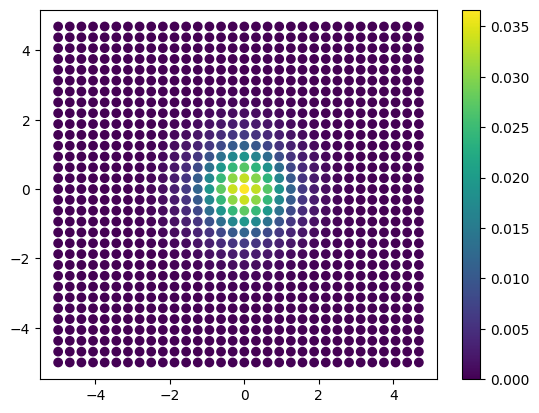

In [9]:
ev_proj = eigenvector_star[:,0]
ev = 0
for i, eig in enumerate(eigs):
  ev += ev_proj[i]*eig
ev_star = eigenvectors[:,0].reshape((N, N, N))

values = np.abs(ev.flatten())**2 / astar**3

ys2d, xs2d = np.indices((N, N))
xs2d = ( (xs2d.flatten() + N / 2) % N - N / 2) * astar
ys2d = ( (ys2d.flatten() + N / 2) % N - N / 2) * astar
plt.scatter(xs2d, ys2d, c=values[:N**2]*astar, cmap='viridis')
plt.colorbar()
plt.show()